In [ ]:
%pip uninstall -y tensorflow
%pip install  tensorflow-gpu==2.2.0
# %pip install Keras==2.2.4

In [2]:
!git clone https://github.com/bonlime/keras-deeplab-v3-plus/

Cloning into 'keras-deeplab-v3-plus'...
remote: Enumerating objects: 384, done.
remote: Total 384 (delta 0), reused 0 (delta 0), pack-reused 384
Receiving objects: 100% (384/384), 5.12 MiB | 13.38 MiB/s, done.
Resolving deltas: 100% (204/204), done.


In [1]:
%cd keras-deeplab-v3-plus/

/content/keras-deeplab-v3-plus


In [2]:
import os
import json
import pickle
import numpy as np
import random
import cv2 as cv
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from matplotlib.pyplot import imsave,imshow
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
HEIGHT, WIDTH = 512, 512

In [ ]:
data = json.load(open('./drive/MyDrive/Stem cells/instances_train2019_EVICAN60.json', 'r'))

In [ ]:
# print(data.keys())
#19859
list_ = []
for n, d in enumerate(data['annotations']):
  if d['image_id'] == 1709:# and d['category_id'] == 52:
    list_.append((n, d['category_id']))
    print(n, d['category_id'])

# print(data['annotations'][19859]['segmentation'])
# print(len(data['annotations'][19859]['segmentation'][0]))
img = Image.new("RGB", (2048, 2048), "black") 

for l,tt in list_:
  if tt == 52:
    img1 = ImageDraw.Draw(img)  
    img1.polygon(data['annotations'][l]['segmentation'][0], fill ="white", outline ="white") 
  else:
    img3 = ImageDraw.Draw(img)  
    img3.polygon(data['annotations'][l]['segmentation'][0], fill ="blue", outline ="blue") 
plt.imshow(img)
plt.show()
  

In [ ]:
train_list = [
  '1634','1637',
  '1638','1639',
  '1640','1641',
  '1642','1644',
  '1645','1646',
  '1647','1648',
  '1649','1650',
  '1651','1652',
  '1653','1654',
  '1655','1656',
  '1675','1676',
  '1677','1678',
  '1681','1682',
  '1683','1684',
  '1685','1686',
  '1697'
]
test_list = [
  '409',
  '410',
  '412',
  '413',
  '414',
  '419'
]
print(len(train_list), len(test_list))

31 6


In [10]:
subdiv = False

In [11]:
train_x = []
train_y = []
train_img_files = os.listdir('../drive/MyDrive/Stem cells/images/images-train/')
train_mask_files = os.listdir('../drive/MyDrive/Stem cells/cells/masks-train/')
train_nuclei_files = os.listdir('../drive/MyDrive/Stem cells/nuclei/masks-train/')
assert (len(train_img_files) == len(train_mask_files) and all(x in train_mask_files for x in train_img_files))
for file_name in train_img_files:
  fileno = file_name.split('_')[0]
  #if not fileno in train_list:
  #  continue
  img = cv.imread(f'../drive/MyDrive/Stem cells/images/images-train/{file_name}')
  # img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img = cv.resize(img, (HEIGHT, WIDTH))
  nuclei = cv.imread(f'../drive/MyDrive/Stem cells/nuclei/masks-train/{file_name}')
  nuclei = cv.cvtColor(nuclei, cv.COLOR_BGR2GRAY)
  nuclei = cv.resize(nuclei, (HEIGHT, WIDTH))
  img = np.stack([img[:,:,0], img[:,:,1], nuclei], axis=-1)
  if subdiv == False:
    train_x.append(img)
  else:
    imgs = [img[y*HEIGHT//2:(y+1)*HEIGHT//2, x*WIDTH//2:(x+1)*WIDTH//2] for x in range(2) for y in range(2)]
    train_x.extend(imgs)
  img = cv.imread(f'../drive/MyDrive/Stem cells/cells/masks-train/{file_name}')
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img = cv.resize(img, (HEIGHT, WIDTH))
  img = (img/img.max()).astype('uint8')
  if subdiv == False:
    train_y.append(img)
  else:
    imgs = [img[y*HEIGHT//2:(y+1)*HEIGHT//2, x*WIDTH//2:(x+1)*WIDTH//2] for x in range(2) for y in range(2)]
    train_y.extend(imgs)
train_x = np.stack(train_x)
train_y = np.stack(train_y)
# test_files = os.listdir('./drive/MyDrive/Stem cells/images-eval/')
# print(len(test_files))
# train_x = np.expand_dims(train_x, axis=-1)
train_y = np.expand_dims(train_y, axis=-1)
print(train_x.shape, train_y.shape, train_x.dtype, train_y.dtype)

(111, 512, 512, 3) (111, 512, 512, 1) uint8 uint8


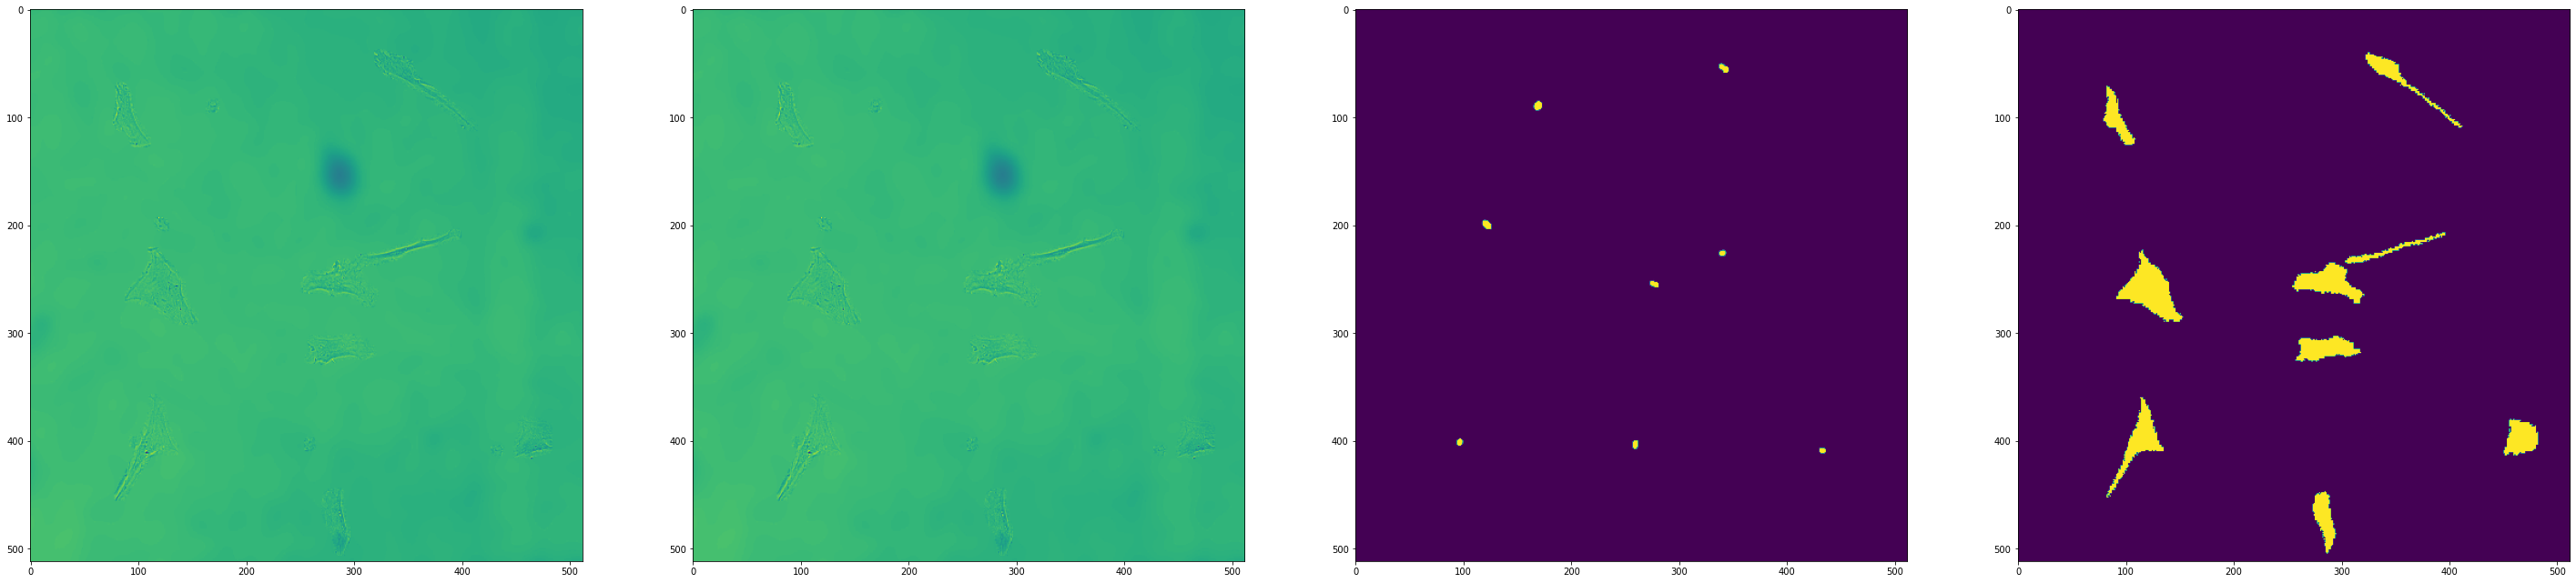

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(50,350))
img0 = train_x[1, :, :, 0]
img1 = train_x[1, :, :, 1]
nn = train_x[1, :, :, 2]
truth = train_y[1, :, :, 0]
axs[0].imshow(img0)
axs[1].imshow(img1)
axs[2].imshow(nn)
axs[3].imshow(truth)
plt.show()

In [13]:
test_x = []
test_y = []
test_img_files = os.listdir('../drive/MyDrive/Stem cells/images/images-eval/')
test_mask_files = os.listdir('../drive/MyDrive/Stem cells/cells/masks-eval/')
test_nuclei_files = os.listdir('../drive/MyDrive/Stem cells/nuclei/masks-val/')
assert (len(test_img_files) == len(test_mask_files) and all(x in test_img_files for x in test_mask_files))
for file_name in test_img_files:
  fileno = file_name.split('_')[0]
  #if not fileno in test_list:
  #  continue
  img = cv.imread(f'../drive/MyDrive/Stem cells/images/images-eval/{file_name}')
  # img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img = cv.resize(img, (HEIGHT, WIDTH))
  nuclei = cv.imread(f'../drive/MyDrive/Stem cells/nuclei/masks-val/{file_name}')
  nuclei = cv.cvtColor(nuclei, cv.COLOR_BGR2GRAY)
  nuclei = cv.resize(nuclei, (HEIGHT, WIDTH))
  img = np.stack([img[:,:,0], img[:,:,1], nuclei], axis=-1)
  if subdiv == False:
    test_x.append(img)
  else:
    imgs = [img[y*HEIGHT//2:(y+1)*HEIGHT//2, x*WIDTH//2:(x+1)*WIDTH//2] for x in range(2) for y in range(2)]
    test_x.extend(imgs)
  img = cv.imread(f'../drive/MyDrive/Stem cells/cells/masks-eval/{file_name}')
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img = cv.resize(img, (HEIGHT, WIDTH))
  img = (img/img.max()).astype('uint8')
  if subdiv == False:
    test_y.append(img)
  else:
    imgs = [img[y*HEIGHT//2:(y+1)*HEIGHT//2, x*WIDTH//2:(x+1)*WIDTH//2] for x in range(2) for y in range(2)]
    test_y.extend(imgs)
test_x = np.stack(test_x)
test_y = np.stack(test_y)
# test_x = np.expand_dims(test_x, axis=-1)
test_y = np.expand_dims(test_y, axis=-1)
print(test_x.shape)
# test_files = os.listdir('./drive/MyDrive/Stem cells/images-eval/')
# print(len(test_files))

(28, 512, 512, 3)


In [14]:
from model import Deeplabv3

In [59]:
from tensorflow.keras import backend as K
import tensorflow as tf

# Compatible with tensorflow backend

# def focal_loss(y_true, y_pred):
#   alpha = 2.
#   gamma = 2.
#   pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#   pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#   return K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def focal_loss(y_true, y_pred, alpha = 0.25, gamma = 2.):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        # y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1 - p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.mean(K.sum(loss, axis=1))
        return loss

def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

def jaccard_coeff(y_true, y_pred):
  return 1 - jaccard_distance(y_true, y_pred, smooth=1)

def hibrid(y_true, y_pred):
    return focal_loss(y_true, y_pred) + jaccard_distance(y_true, y_pred)
    #return focal_loss(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

In [60]:
inputsize = (HEIGHT//2, WIDTH//2, 3) if subdiv else (HEIGHT, WIDTH, 3)
# deeplab_model = Deeplabv3( input_shape=inputsize, classes=1, activation='sigmoid', backbone='mobilenetv2')#, backbone=mobilenetv2"xception")  
deeplab_model = Deeplabv3(weights='cityscapes', input_shape=inputsize, classes=1, activation='sigmoid', backbone='mobilenetv2')#, backbone=mobilenetv2"xception")

In [61]:
sgd = tf.keras.optimizers.SGD(
    learning_rate=0.001, decay= 0.000001, momentum=0.0, nesterov=False, name="SGD"
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

deeplab_model.compile(optimizer='adam', loss=hibrid, metrics=['acc', dice_coef, jaccard_coeff])

In [62]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.1)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train_x)
del datagen

In [63]:
# train_history = deeplab_model.fit(datagen.flow(train_x, train_y, batch_size=8,
#          subset='training'),
#          validation_data=datagen.flow(train_x, train_y,
#          batch_size=8, subset='validation'),
#          steps_per_epoch=4, epochs=100)

train_history = deeplab_model.fit(train_x, train_y, epochs=100, batch_size=8,  callbacks=[early_stopping], validation_split=0.01)

Epoch 1/100
14/14 [==============================] - 8s 606ms/step - loss: 236.7479 - acc: 0.6082 - dice_coef: 0.8237 - jaccard_coeff: 0.1132 - val_loss: 269.3209 - val_acc: 0.9177 - val_dice_coef: 0.9588 - val_jaccard_coeff: 4.7088e-05
Epoch 2/100
14/14 [==============================] - 7s 494ms/step - loss: 75.6062 - acc: 0.9813 - dice_coef: 0.9832 - jaccard_coeff: 0.3242 - val_loss: 267.5534 - val_acc: 0.9177 - val_dice_coef: 0.9588 - val_jaccard_coeff: 4.7207e-05
Epoch 3/100
14/14 [==============================] - 7s 499ms/step - loss: 56.5489 - acc: 0.9873 - dice_coef: 0.9923 - jaccard_coeff: 0.4912 - val_loss: 245.0291 - val_acc: 0.8913 - val_dice_coef: 0.9448 - val_jaccard_coeff: 0.0014
Epoch 4/100
14/14 [==============================] - 7s 493ms/step - loss: 47.0144 - acc: 0.9884 - dice_coef: 0.9948 - jaccard_coeff: 0.5823 - val_loss: 802.8148 - val_acc: 0.5173 - val_dice_coef: 0.7719 - val_jaccard_coeff: 0.0122
Epoch 5/100
14/14 [==============================] - 7s 493ms/s

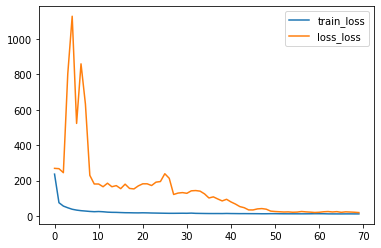

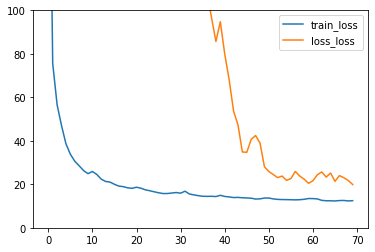

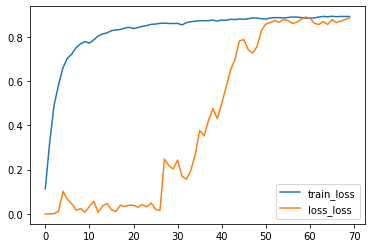

In [86]:
history = train_history.history
plt.plot(history['loss'][:70], label='train_loss')
plt.plot(history['val_loss'][:70], label='loss_loss')
plt.legend()
# plt.ylim([0, 100])
plt.savefig('./loss.png')
plt.show()

plt.plot(history['loss'][:70], label='train_loss')
plt.plot(history['val_loss'][:70], label='loss_loss')
plt.legend()
plt.ylim([0, 100])
plt.savefig('./loss_1.png')
plt.show()

plt.plot(history['jaccard_coeff'][:70], label='train_loss')
plt.plot(history['val_jaccard_coeff'][:70], label='loss_loss')
plt.legend()
# plt.ylim([0, 100])
plt.savefig('./jaccard_coeff.png')
plt.show()

In [78]:
deeplab_model.save_weights('../drive/MyDrive/Dental/stem_cells_model_mobilenet_3.h5')

In [ ]:
deeplab_model.load_weights('../drive/MyDrive/Dental/stem_cells_model_xception_2.h5')

(1, 512, 512, 1) (1, 512, 512, 1)
1.0 1.0455427e-31


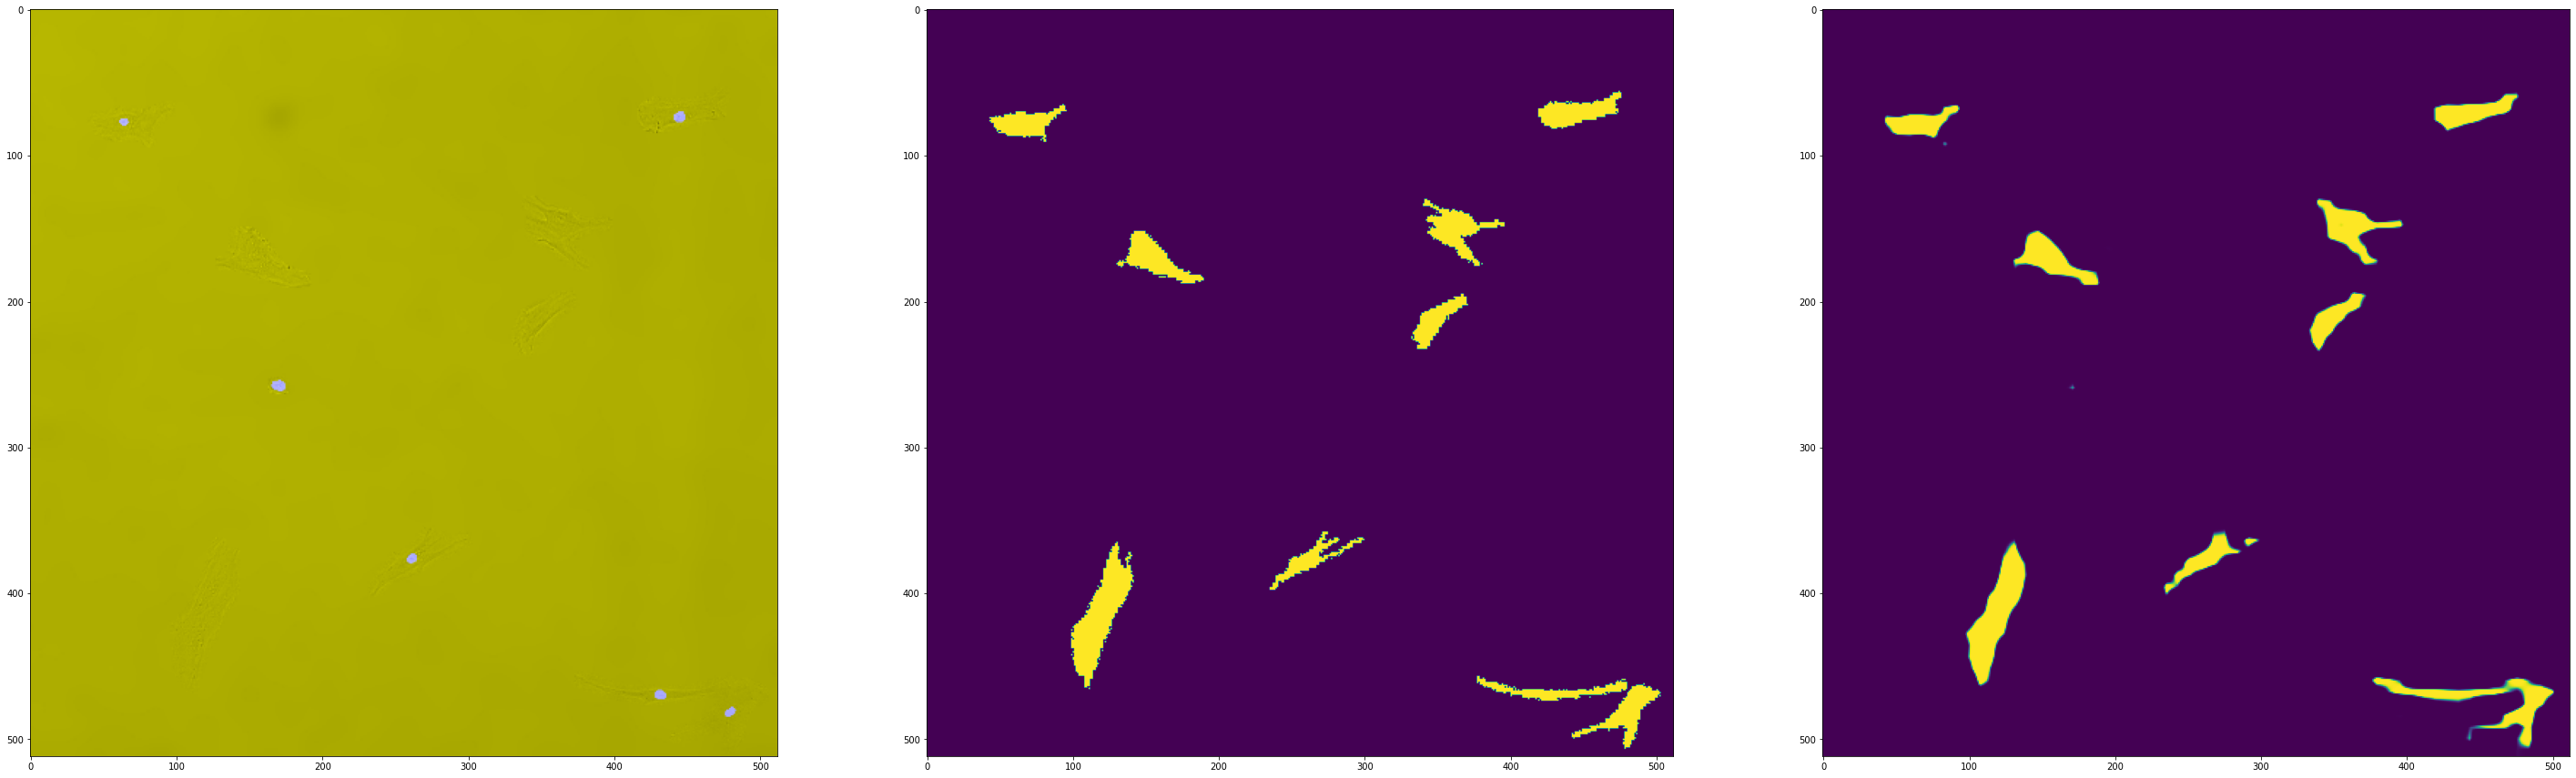

(1, 512, 512, 1) (1, 512, 512, 1)
1.0 3.8688808e-32


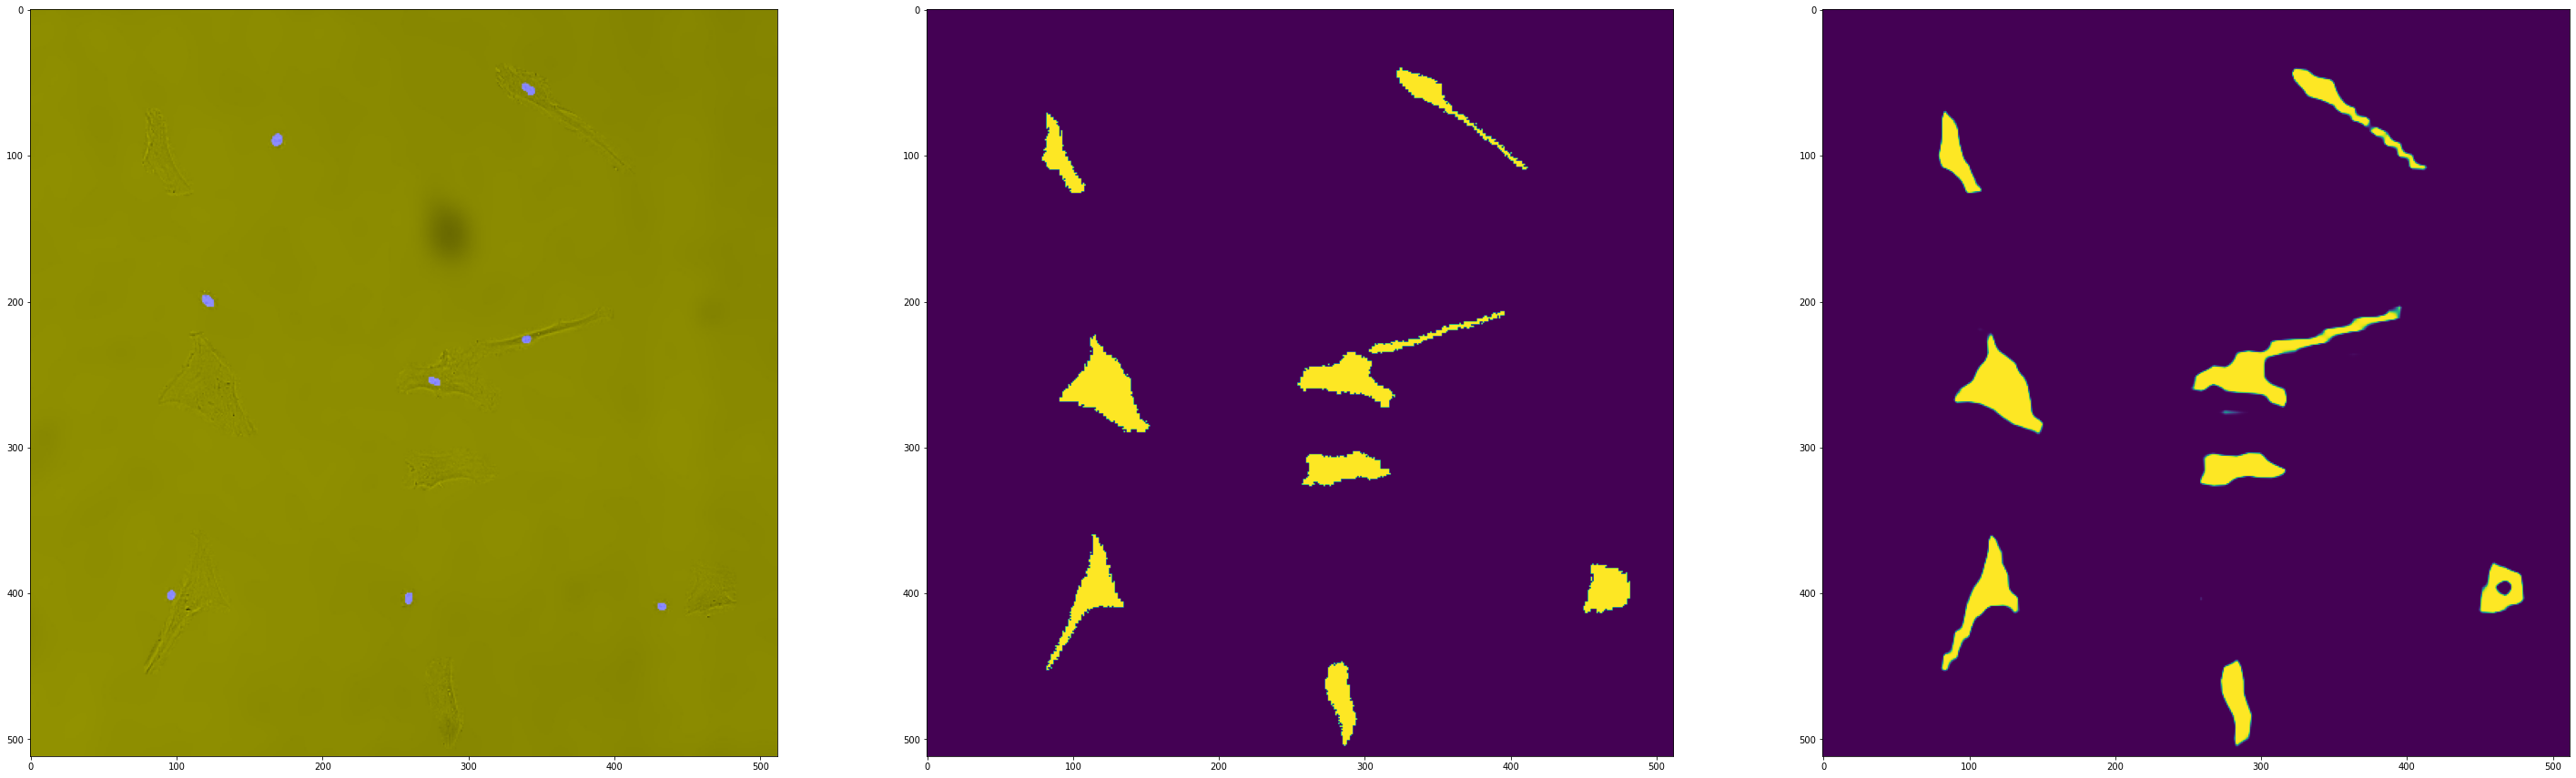

In [79]:
for i in range(2):
  fig, axs = plt.subplots(1, 3, figsize=(50,350))
  img = train_x[i:i+1, :, :]
  truth = train_y[i:i+1, :, :]
  pred = deeplab_model.predict(img, batch_size = 1)
  # pred = pred/pred.max()
  # pred[pred < 0.5] = 0
  # pred[pred >= 0.5] = 1
  print(pred.shape, truth.shape)
  print(pred.max(), pred.min())
  # print(truth[0,:,:,0].min(), truth[0,:,:,0].max())
  axs[0].imshow(img[0,:,:])
  axs[1].imshow(truth[0,:,:,0]*255)
  axs[2].imshow(pred[0,:,:,0])
  plt.show()
  # break

In [87]:
deeplab_model.summary()

Model: "deeplabv3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 256, 256, 32) 864         input_9[0][0]                    
__________________________________________________________________________________________________
Conv_BN (BatchNormalization)    (None, 256, 256, 32) 128         Conv[0][0]                       
__________________________________________________________________________________________________
Conv_Relu6 (Activation)         (None, 256, 256, 32) 0           Conv_BN[0][0]                    
______________________________________________________________________________________

In [83]:
deeplab_model.evaluate(test_x, test_y)

1/1 [==============================] - 0s 2ms/step - loss: 23.9392 - acc: 0.9922 - dice_coef: 0.9966 - jaccard_coeff: 0.8412


[23.93918228149414, 0.9922317862510681, 0.9965758323669434, 0.8412266969680786]

In [ ]:
deeplab_model.evaluate(test_x, test_y)

1/1 [==============================] - 0s 2ms/step - loss: 32.9607 - acc: 0.9337 - dice_coef: 0.9695 - mean_io_u_4: 0.4696


[32.960655212402344,
 0.9337034225463867,
 0.9695010185241699,
 0.4696296155452728]

In [82]:
for i in range(28):
  fig, axs = plt.subplots(1, 4, figsize=(30,200))
  img = test_x[i:i+1, :, :]
  truth = test_y[i:i+1, :, :]
  pred = deeplab_model.predict(img, batch_size = 1)
  pred = pred/pred.max()
  print(pred.shape, truth.shape)
  print(pred.max(), pred.min())
  # print(truth[0,:,:,0].min(), truth[0,:,:,0].max())
  axs[0].imshow(img[0,:,:])
  axs[1].imshow(truth[0,:,:,0]*255)
  axs[2].imshow(pred[0,:,:,0])
  pred[pred < 0.5] = 0
  pred[pred >= 0.5] = 1
  axs[3].imshow(pred[0,:,:,0])
  plt.savefig(f'../imgs/{i}.png')
  plt.show()
  # break

Output hidden; open in https://colab.research.google.com to view.

In [84]:
%cd ../
%ls 
!zip -r ./imgs.zip ./imgs/

/content
drive/  imgs/  keras-deeplab-v3-plus/  sample_data/
  adding: imgs/ (stored 0%)
  adding: imgs/18.png (deflated 55%)
  adding: imgs/12.png (deflated 72%)
  adding: imgs/10.png (deflated 62%)
  adding: imgs/13.png (deflated 69%)
  adding: imgs/21.png (deflated 73%)
  adding: imgs/25.png (deflated 68%)
  adding: imgs/7.png (deflated 62%)
  adding: imgs/19.png (deflated 68%)
  adding: imgs/22.png (deflated 67%)
  adding: imgs/5.png (deflated 72%)
  adding: imgs/14.png (deflated 69%)
  adding: imgs/23.png (deflated 60%)
  adding: imgs/9.png (deflated 67%)
  adding: imgs/27.png (deflated 61%)
  adding: imgs/4.png (deflated 62%)
  adding: imgs/8.png (deflated 66%)
  adding: imgs/26.png (deflated 61%)
  adding: imgs/15.png (deflated 66%)
  adding: imgs/2.png (deflated 66%)
  adding: imgs/6.png (deflated 61%)
  adding: imgs/16.png (deflated 50%)
  adding: imgs/24.png (deflated 70%)
  adding: imgs/17.png (deflated 51%)
  adding: imgs/3.png (deflated 64%)
  adding: imgs/20.png (deflated

In [ ]:
for i in range(6):
  fig, axs = plt.subplots(1, 4, figsize=(30,200))
  img = test_x[i:i+1, :, :]
  truth = test_y[i:i+1, :, :]
  pred = deeplab_model.predict(img, batch_size = 1)
  pred = pred/pred.max()
  pred[pred < 0.5] = 0
  pred[pred >= 0.5] = 1
  print(pred.shape, truth.shape)
  print(pred.max(), pred.min())
  # print(truth[0,:,:,0].min(), truth[0,:,:,0].max())
  axs[0].imshow(img[0,:,:])
  axs[1].imshow(truth[0,:,:,0]*255)
  axs[2].imshow(pred[0,:,:,0])
  pred[pred < 0.5] = 0
  pred[pred >= 0.5] = 1
  axs[3].imshow(pred[0,:,:,0])
  plt.show()
  # break

Output hidden; open in https://colab.research.google.com to view.